In [ ]:
Quantas retiradas de barra é bom
melhor seção

In [1]:
import sys
sys.path.insert(0, '../')
import fconcrete as fc
import matplotlib.pyplot as plt
from pytest import approx
import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=3000)
from math import sin, tan,  pi
from fconcrete.helpers import cond
import copy

In [2]:
material = fc.Concrete('20 MPa', 1)
section = fc.Rectangle(25,60)

f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0, length=20)
n2 = fc.Node.SimpleSupport(x=113, length=20)
n3 = fc.Node.SimpleSupport(x=583, length=20)
n4 = fc.Node.SimpleSupport(x=1188, length=20)

bar1 = fc.BeamElement([n1, n2], section, material)
bar2 = fc.BeamElement([n2, n3], section, material)
bar3 = fc.BeamElement([n3, n4], section, material)

    
beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    bar_steel_max_removal = 3,
    transversal_bar_inclination_angle=90,
    available_long_steel_bars = fc.AvailableLongConcreteSteelBar(diameters=[8]),
    available_transv_steel_bars = fc.AvailableTransvConcreteSteelBar(diameters=[8])
)

In [8]:
self = beam

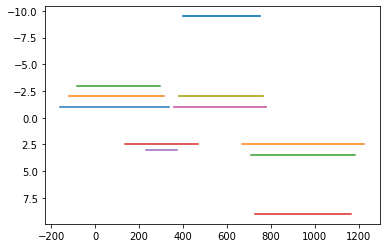

In [9]:
self.long_steel_bars.plot()

In [19]:
x=1000
positive_bars, negative_bars = self.long_steel_bars.getPositiveandNegativeLongSteelBarsInX(x=x)

In [20]:
_, beam_element = self.getBeamElementInX(x)

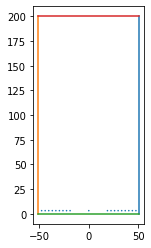

In [23]:
bars = positive_bars
fig, ax = plt.subplots()
ax.set_aspect("equal")

height = 200

y = np.linspace(0, height, 100)
x = np.cos(y)/np.cos(y)+50

x_base = np.linspace(-x[0], x[0], 100)
x_top = np.linspace(-x[-1], x[-1], 100)

ax.plot(x, y)
ax.plot(2*y[0]-x, y)
ax.plot(x_base,np.zeros(len(y)))
ax.plot(x_top,height*np.ones(len(y)))

x0, y0 = -x[0], y[0]
x0_left, x0_right = x0+beam_element.material.c, -x0-beam_element.material.c

radius = max(abs(bars.diameters))
horizontal_distance = max(2, 2*radius, 1.2*self.biggest_aggregate_dimension)
vertical_distance = max(2, 2*radius, 0.5*self.biggest_aggregate_dimension)

number_of_bars = max(abs(bars.quantities_accumulated))
n = 0
bar_in_the_left = row_number =True

while n<number_of_bars+1:
    
    y_row = y0+beam_element.material.c+radius*row_number+(vertical_distance+radius)*(row_number-1)
    if bar_in_the_left:
        circle = plt.Circle((x0_left+radius, y_row), radius)
        x0_left+=2*radius+horizontal_distance
    else:
        circle = plt.Circle((x0_right-radius, y_row), radius)
        x0_right-=2*radius+horizontal_distance
        
    space_between_bars = x0_right-x0_left-2*horizontal_distance
    possible_bar_in_row = (space_between_bars+horizontal_distance)//(2*radius+horizontal_distance)
    # Nao tem espaco para colcoar nenhuma depois
    if possible_bar_in_row==0:
        row_number+=1
        x0_left = x0+c
        x0_right = -x0-c
        bar_in_the_left = False
    elif (possible_bar_in_row==1 and bar_in_the_left) or (n == number_of_bars):
        circle = plt.Circle((0, y_row), radius)
        ax.add_artist(circle)
    else:
        ax.add_artist(circle)
    n+=1
    bar_in_the_left = not bar_in_the_left



In [83]:
not 0

True

In [58]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

height = 20

y = np.linspace(0, height, 100)
x = np.cos(y)/np.cos(y)+5

x_base = np.linspace(-x[0], x[0], 100)
x_top = np.linspace(-x[-1], x[-1], 100)


ax.plot(x, y)
ax.plot(2*y[0]-x, y)
ax.plot(x_base,np.zeros(len(y)))
ax.plot(x_top,height*np.ones(len(y)))

x0, y0 = -x[0], y[0]
x0_left = x0+c
x0_right = -x0-c
radius = 0.2
horizontal_distance = 0.2
vertical_distance = 0.2
row_number = 1

number_of_bars = 40
n = 0
bar_in_the_left = True
while n<number_of_bars+1:
    
    y_row = y0+c+radius*row_number+(vertical_distance+radius)*(row_number-1)
    if bar_in_the_left:
        circle = plt.Circle((x0_left+radius, y_row), radius)
        x0_left+=2*radius+horizontal_distance
    else:
        circle = plt.Circle((x0_right-radius, y_row), radius)
        x0_right-=2*radius+horizontal_distance
        
    space_between_bars = x0_right-x0_left-2*horizontal_distance
    possible_bar_in_row = (space_between_bars+horizontal_distance)//(2*radius+horizontal_distance)
    # Nao tem espaco para colcoar nenhuma depois
    if possible_bar_in_row==0:
        row_number+=1
        x0_left = x0+c
        x0_right = -x0-c
        bar_in_the_left = False
    elif (possible_bar_in_row==1 and bar_in_the_left) or (n == number_of_bars):
        circle = plt.Circle((0, y_row), radius)
        ax.add_artist(circle)
    else:
        ax.add_artist(circle)
    n+=1
    bar_in_the_left = not bar_in_the_left



[]

In [47]:
x[0]

10.00442569798805

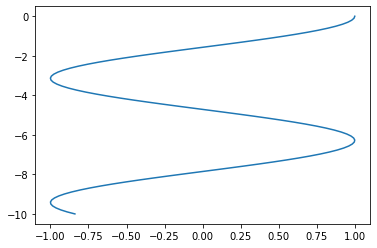

In [14]:
plt.plot(y, -x)

In [6]:
self = beam.transv_steel_bars_solution_info

In [10]:
beam.transv_steel_bars

[{'x': 0.0, 'height': 55.0, 'width': 20.0, 'diameter': 8.0, 'space_after': 30.0, 'area': 1.0, 'as_per_cm': 0.03333333333333333}
 {'x': 30.0, 'height': 55.0, 'width': 20.0, 'diameter': 8.0, 'space_after': 30.0, 'area': 1.0, 'as_per_cm': 0.03333333333333333}
 {'x': 60.0, 'height': 55.0, 'width': 20.0, 'diameter': 8.0, 'space_after': 30.0, 'area': 1.0, 'as_per_cm': 0.03333333333333333}
 {'x': 90.0, 'height': 55.0, 'width': 20.0, 'diameter': 8.0, 'space_after': 30.0, 'area': 1.0, 'as_per_cm': 0.03333333333333333}
 {'x': 120.0, 'height': 55.0, 'width': 20.0, 'diameter': 8.0, 'space_after': 30.0, 'area': 1.0, 'as_per_cm': 0.03333333333333333}
 {'x': 150.0, 'height': 55.0, 'width': 20.0, 'diameter': 8.0, 'space_after': 30.0, 'area': 1.0, 'as_per_cm': 0.03333333333333333}
 {'x': 180.0, 'height': 55.0, 'width': 20.0, 'diameter': 8.0, 'space_after': 30.0, 'area': 1.0, 'as_per_cm': 0.03333333333333333}
 {'x': 210.0, 'height': 55.0, 'width': 20.0, 'diameter': 8.0, 'space_after': 30.0, 'area': 1.0,